In [ ]:
# Due the different version of python can be found and each machine or libriries 
# I just decided to use this library to avoid distraction and anoing warnigs
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

## Licence of use

Working with Room Occupancy Estimation: That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation
licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/

## About the dataset

    -> The experimental testbed for occupancy estimation was deployed in a 6m x 4.6m room. The setup consisted of 7 sensor nodes and one edge node in a star configuration with the sensor nodes transmitting data to the edge every 30s using wireless transceivers.
    -> The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Occupancy Estimation") \
    .getOrCreate()

24/03/26 12:11:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# Loading dataset from HDFS - Biga data Tecnology to storage
df = spark.read.csv("hdfs:///user1/Occupancy_Estimation.csv", header=True, inferSchema=True)

# Data Exploration
    - as EDA

In [4]:
# Print the schema to understand the data types
df.printSchema()

# Summary statistics for numerical columns
df.describe().show()

root
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable = true)
 |-- S1_Light: integer (nullable = true)
 |-- S2_Light: integer (nullable = true)
 |-- S3_Light: integer (nullable = true)
 |-- S4_Light: integer (nullable = true)
 |-- S1_Sound: double (nullable = true)
 |-- S2_Sound: double (nullable = true)
 |-- S3_Sound: double (nullable = true)
 |-- S4_Sound: double (nullable = true)
 |-- S5_CO2: integer (nullable = true)
 |-- S5_CO2_Slope: double (nullable = true)
 |-- S6_PIR: integer (nullable = true)
 |-- S7_PIR: integer (nullable = true)
 |-- Room_Occupancy_Count: integer (nullable = true)



24/03/26 12:11:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+-------------------+-------------------+--------------------+
|summary|      Date|           S1_Temp|           S2_Temp|            S3_Temp|           S4_Temp|          S1_Light|          S2_Light|         S3_Light|         S4_Light|           S1_Sound|           S2_Sound|           S3_Sound|           S4_Sound|            S5_CO2|        S5_CO2_Slope|             S6_PIR|             S7_PIR|Room_Occupancy_Count|
+-------+----------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+---

# Preprocessing the dataset with PySpark 
    
     - Checking for Missing Values
     - Cleaning features that won't be used by the LSTM --> Feature Engineering
     - Converting to a Pandas Df to preprocecing
     - Normalization

In [5]:
from pyspark.sql.functions import col, count

# Count the total number of entries
total_entries = df.count()

# Count the number of non-null (non-missing) values in each column
non_missing_counts = df.agg(*(count(c).alias(c) for c in df.columns))

# To view the results
non_missing_counts.show()

# Calculating missing values by subtracting non-missing from total entries
# This involves converting the DataFrame to a Pandas DataFrame for easier manipulation
non_missing_counts_pandas = non_missing_counts.toPandas()
missing_values = total_entries - non_missing_counts_pandas.iloc[0]
print("Missing values in each column:\n", missing_values)


+-----+-----+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+
| Date| Time|S1_Temp|S2_Temp|S3_Temp|S4_Temp|S1_Light|S2_Light|S3_Light|S4_Light|S1_Sound|S2_Sound|S3_Sound|S4_Sound|S5_CO2|S5_CO2_Slope|S6_PIR|S7_PIR|Room_Occupancy_Count|
+-----+-----+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+
|10129|10129|  10129|  10129|  10129|  10129|   10129|   10129|   10129|   10129|   10129|   10129|   10129|   10129| 10129|       10129| 10129| 10129|               10129|
+-----+-----+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+

Missing values in each column:
 Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 

# Features and Target

 - Target is predict Room Ocuppancy which is(Room_Occupancy_Count)
 - All the sensors readings would be the features to be analysed
 - Let's perform a better Feature Engineering - separating onto differents df

In [6]:
# Separating features and target variable
feature_columns = [col for col in df.columns if col not in {'Date', 'Time', 'Room_Occupancy_Count'}]
features_df = df.select(*feature_columns)
target_df = df.select('Room_Occupancy_Count')

In [7]:
# features_df and target_df are a Spark DataFrames also, convert those to Pandas for normalization(Features)
pandas_features_df = features_df.toPandas()
pandas_target_df = target_df.toPandas()

In [8]:
# Normalizing the data
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler for features
scaler_features = MinMaxScaler(feature_range=(0, 1))
# Fit and transform the features
pandas_features_df_scaled = pd.DataFrame(scaler_features.fit_transform(pandas_features_df),
                                         columns=pandas_features_df.columns)

scaler_target = MinMaxScaler(feature_range=(0, 1))
# As the target Df is a single column and needs to be reshaped for scaling
pandas_target_df_scaled = scaler_target.fit_transform(pandas_target_df.values.reshape(-1, 1))
# Flatten back to a series maintaining the original index
pandas_target_df_scaled = pd.Series(pandas_target_df_scaled.flatten(), index=pandas_target_df.index)

# pandas_features_df_scaled -> Normalized features
# pandas_target_df_scaled -> Normalized target 


Inverse Transformation: as was normalized the target variable, keep the scaler_target object so it will needs later  to use scaler_target.inverse_transform() on top of predictions, in order to interpret the results in the original scale of the target variable.

In [9]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features.iloc[i:(i + time_steps)].values)
        y.append(target.iloc[i + time_steps])
    return np.array(X), np.array(y)

# Pandas_features_df_scaled and pandas_target_df_scaled are feature and target dataframes
X, y = create_sequences(pandas_features_df_scaled, pandas_target_df, time_steps=60)


In [10]:
# Splitting time series data for LSTM models, ensuring the split preserves the sequence's temporal order
# Determine the split point for an 80/20 train-test split
split_point = int(len(pandas_features_df_scaled) * 0.8)

# Splitting the features
X_train = pandas_features_df_scaled.iloc[:split_point]
X_test = pandas_features_df_scaled.iloc[split_point:]

# Check if the target has been scaled and split accordingly
# This checks if 'pandas_target_df_scaled' has been defined and uses it; if not, it falls back to 'pandas_target_df'
if 'pandas_target_df_scaled' in locals():
    y_train = pandas_target_df_scaled.iloc[:split_point]
    y_test = pandas_target_df_scaled.iloc[split_point:]
else:
    y_train = pandas_target_df.iloc[:split_point]
    y_test = pandas_target_df.iloc[split_point:]


In [21]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8103, 16) (8103,) (2026, 16) (2026,)


In [13]:
print(X.shape)

(10069, 60, 16)


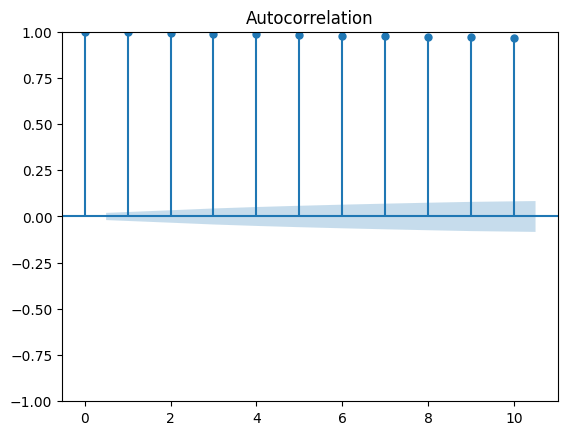

In [19]:
# To understand whcih steps would be better to the model with that data set.

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# `pandas_target_df` is a Pandas df before normalization of target variable
plot_acf(pandas_target_df, lags=10)  # Adjust 'lags' based on dataset size and interest
plt.show()

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')